### Old Method

In [1]:
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import inception_v3
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import models
from keras import layers
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from util.plots import plot_history

Using TensorFlow backend.


In [2]:
train_path = 'res_still/train'
valid_path = 'res_still/valid'
test_path = 'res_still/test'

batch_size = 32

train_datagen = ImageDataGenerator(
        rescale=1./255,
        vertical_flip=True,
        horizontal_flip=True,
        brightness_range=(0.65, 1.35))

valid_datagen = ImageDataGenerator(
        rescale=1./255
)

# Train data generator
train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(299, 299),
        batch_size=batch_size,
        classes=['potato', 'catfood', 'table'])

# Validation data generator
validation_generator = valid_datagen.flow_from_directory(
        valid_path,
        target_size=(299, 299),
        batch_size=batch_size,
        classes=['potato', 'catfood', 'table'])

# this is a similar generator, for validation data
test_generator = valid_datagen.flow_from_directory(
        test_path,
        target_size=(299, 299),
        batch_size=50,
        classes=['potato', 'catfood', 'table'])

Found 355 images belonging to 3 classes.
Found 100 images belonging to 3 classes.
Found 50 images belonging to 3 classes.


In [5]:
base_model = inception_v3.InceptionV3(include_top=False, weights='imagenet', input_shape=(299,299, 3))

In [6]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
history1 = model.fit_generator(
              train_generator,
              steps_per_epoch=355 // batch_size,
              epochs=100,
              validation_data=validation_generator,
              validation_steps= 100 // batch_size)

Epoch 1/100
11/11 [==============================] - 12s 1s/step - loss: 0.8614 - acc: 0.6623 - val_loss: 0.7106 - val_acc: 0.7708
Epoch 2/100
11/11 [==============================] - 6s 589ms/step - loss: 0.4322 - acc: 0.9290 - val_loss: 0.4161 - val_acc: 0.9118
Epoch 3/100
11/11 [==============================] - 5s 494ms/step - loss: 0.3902 - acc: 0.8940 - val_loss: 0.6576 - val_acc: 0.5294
Epoch 4/100
11/11 [==============================] - 6s 527ms/step - loss: 0.2981 - acc: 0.9176 - val_loss: 0.4797 - val_acc: 0.8088
Epoch 5/100
11/11 [==============================] - 6s 518ms/step - loss: 0.2365 - acc: 0.9575 - val_loss: 0.3510 - val_acc: 0.9271
Epoch 6/100
11/11 [==============================] - 7s 608ms/step - loss: 0.1440 - acc: 0.9801 - val_loss: 0.2253 - val_acc: 0.9265
Epoch 7/100
11/11 [==============================] - 5s 496ms/step - loss: 0.2044 - acc: 0.9237 - val_loss: 0.7259 - val_acc: 0.5294
Epoch 8/100
11/11 [==============================] - 5s 461ms/step - lo

In [ ]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy')

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
history2 = model.fit_generator(
              train_generator,
              steps_per_epoch=446 // batch_size,
              epochs=50,
              validation_data=validation_generator,
              validation_steps= 150 // batch_size)

<b>Plot</b>

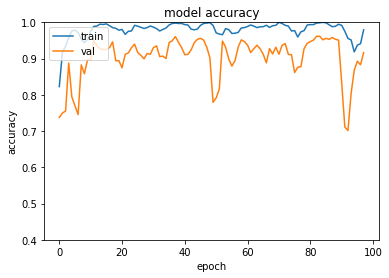

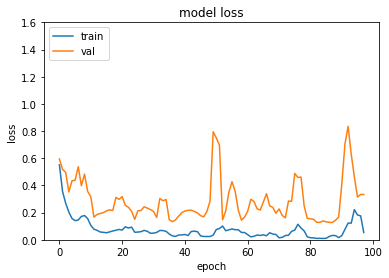

In [10]:
plot_history(history1, mean_N=3, ylim_acc=(0.4,1.0),ylim_loss=(0.0,1.6), save=True, path='nets/inceptionV3_net/', name='plot2')

In [ ]:
plot_history(history2, mean_N=3)

In [9]:
imgs, labels = next(test_generator)

model.evaluate(imgs,labels, batch_size=50)

50/50 [==============================] - 3s 64ms/step


[0.2388392686843872, 0.9399999976158142]

### New method

In [1]:
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras import layers
from keras.models import Model, Sequential
from keras.applications import inception_v3
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from util.plots import plot_history
from glob import glob
import util.image_import as ii
from util.data_generator import make_data_generator
import os


Using TensorFlow backend.


In [2]:
batch_size = 32
train_path = '../dataset3/res_still/train'
test_path = '../dataset3/res_still/test'
train_generator, test_generator = make_data_generator(train_path, test_path, val_path="", load_ram=True)

Found Training 1875 images belonging to 8 classes
Found Test 472 images belonging to 8 classes


**Downloading and defining the basemodel of network inception**

In [3]:
base_model = inception_v3.InceptionV3(include_top=False, weights='imagenet', input_shape=(224,224, 3))

**Adding the last layers to network inception**

In [4]:
model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(8, activation='softmax'))
base_model.trainable = False # freeze the inseption model
model.compile(loss='categorical_crossentropy',
                        optimizer=Adam(lr=1e-3),
                        metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               13107456  
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 2056      
Total params: 34,912,296
Trainable params: 13,109,512
Non-trainable params: 21,802,784
_________________________________________________________________


In [5]:
history = model.fit_generator(
            train_generator,
            steps_per_epoch=1875 // batch_size,
            epochs=100,
            validation_data=test_generator,
            validation_steps=472 // batch_size,
            use_multiprocessing=True,
            workers=2)

Epoch 1/100
58/58 [==============================] - 17s 290ms/step - loss: 13.3916 - acc: 0.1487 - val_loss: 13.4260 - val_acc: 0.1607
Epoch 2/100
58/58 [==============================] - 13s 223ms/step - loss: 13.5160 - acc: 0.1525 - val_loss: 12.3351 - val_acc: 0.2188
Epoch 3/100
58/58 [==============================] - 13s 219ms/step - loss: 13.0870 - acc: 0.1843 - val_loss: 13.7436 - val_acc: 0.1429
Epoch 4/100
58/58 [==============================] - 13s 226ms/step - loss: 12.9678 - acc: 0.1934 - val_loss: 13.3806 - val_acc: 0.1652
Epoch 5/100
58/58 [==============================] - 15s 256ms/step - loss: 12.6317 - acc: 0.2125 - val_loss: 12.5567 - val_acc: 0.2188
Epoch 6/100
58/58 [==============================] - 15s 250ms/step - loss: 12.4086 - acc: 0.2279 - val_loss: 12.9785 - val_acc: 0.1897
Epoch 7/100
58/58 [==============================] - 14s 240ms/step - loss: 12.4706 - acc: 0.2242 - val_loss: 12.6333 - val_acc: 0.2143
Epoch 8/100
58/58 [=============================

Epoch 61/100
58/58 [==============================] - 14s 244ms/step - loss: 6.2103 - acc: 0.5915 - val_loss: 7.5210 - val_acc: 0.5179
Epoch 62/100
58/58 [==============================] - 14s 244ms/step - loss: 5.5472 - acc: 0.6177 - val_loss: 8.1167 - val_acc: 0.4554
Epoch 63/100
58/58 [==============================] - 15s 256ms/step - loss: 5.2022 - acc: 0.6197 - val_loss: 8.2613 - val_acc: 0.4107
Epoch 64/100
58/58 [==============================] - 14s 234ms/step - loss: 4.9639 - acc: 0.6133 - val_loss: 7.1800 - val_acc: 0.4397
Epoch 65/100
58/58 [==============================] - 14s 238ms/step - loss: 3.6136 - acc: 0.6062 - val_loss: 3.5668 - val_acc: 0.4040
Epoch 66/100
58/58 [==============================] - 14s 242ms/step - loss: 1.3224 - acc: 0.6091 - val_loss: 2.5958 - val_acc: 0.4308
Epoch 67/100
58/58 [==============================] - 14s 244ms/step - loss: 1.0614 - acc: 0.6485 - val_loss: 2.8859 - val_acc: 0.4420
Epoch 68/100
58/58 [==============================] - 1

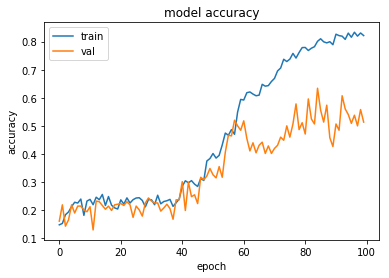

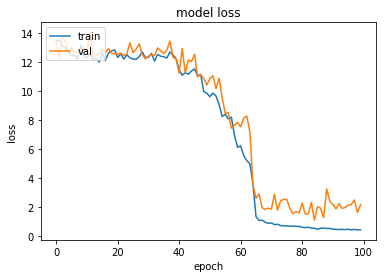

In [6]:
plot_history(history)